In this notebook, we are going to analyze the data previously downloaded in the notebook <code>load_data.ipynb</code> using the <b>Wykop API</b> and saved into CSV files. We will show some basic statistics, investigate data distributions, and look for correlations among variables. Let's start by importing the necessary modules:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import seaborn as sns

Now we load the requested files using the pandas method <code>read_csv</code>. If any file is missing or incorrect, we print the appropriate information. For convenience, parameters are placed in a separate cell.

In [2]:
load_data = ['humorobrazkowy', 'heheszki','pokazmorde', 'gownowpis'] # filenames of CSV files we want to load (without extention)
data_folder_path = "data" # path to folder containing CSV files

In [3]:
raw_data = {}

print("Loading data...")
for filename in load_data:
    try:
        path = f"{data_folder_path}/{filename}.csv"
        raw_data[filename] = pd.read_csv(path, parse_dates = ['created_at'])
    except:
        print("Error loading", filename)

# Print information about loaded data
print(f"Loaded {len(raw_data)} tables with shapes: ")
for index in raw_data:
    print(f"* {index}: {raw_data[index].shape}")

Loading data...
Loaded 4 tables with shapes: 
* humorobrazkowy: (1462, 21)
* heheszki: (2000, 21)
* pokazmorde: (105, 21)
* gownowpis: (1290, 21)


We successfully loaded the data! Let's start by creating a histogram that will show us activity (i.e., the number of new posts in each hour) over time:

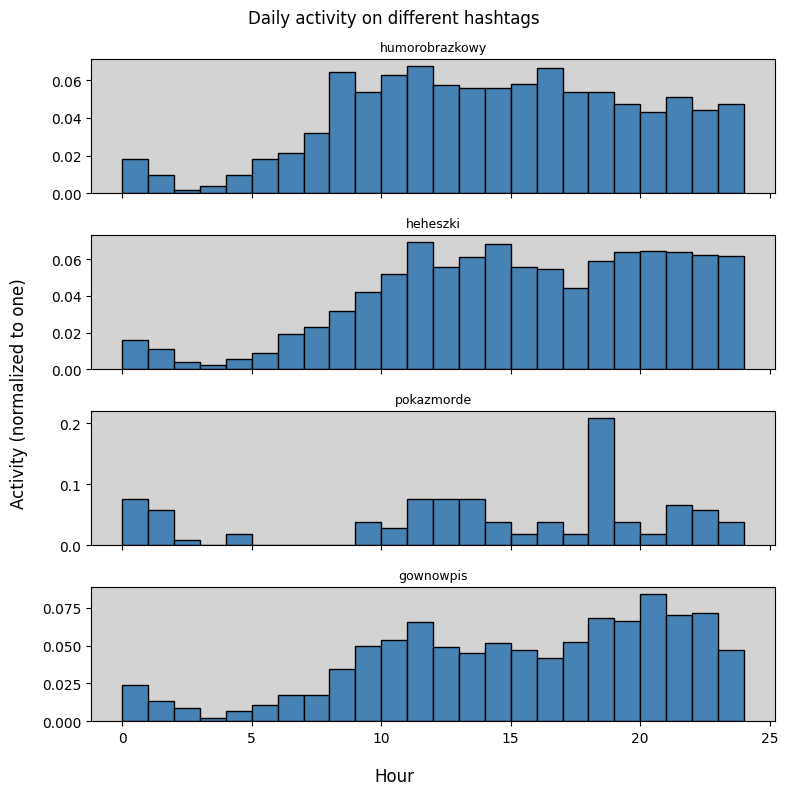

In [4]:
#TODO Change ytics to format as percent value, make ylabel position at center

fig, axs = plt.subplots(len(raw_data), figsize=(8,8), sharex=True, sharey=False)
fig.set_tight_layout(True) # prevents overlaping
fig.suptitle("Daily activity on different hashtags")
fig.supylabel('Activity (normalized to one)')
fig.supxlabel('Hour')

for index, ax in zip(raw_data, axs):
    ax.set_title(index, fontdict={"fontsize": 9})
    table = raw_data[index]['created_at'].dt.hour
    bins = [i for i in range(25)]
    table.hist(bins=bins, grid=False, density=True, ax=ax, color="steelblue", edgecolor="black")
    ax.set_facecolor("lightgray")
plt.show()

Now let's try to do the same thing, but this time broken down by the author's gender. We are going to use the <code>author</code> column, which contains dictionaries with data describing the author of the post. The problem is that it is loaded as a string. To load it as an actual dictionary, we are going to use the <code>literal_eval</code> method from the <code>ast</code> module.

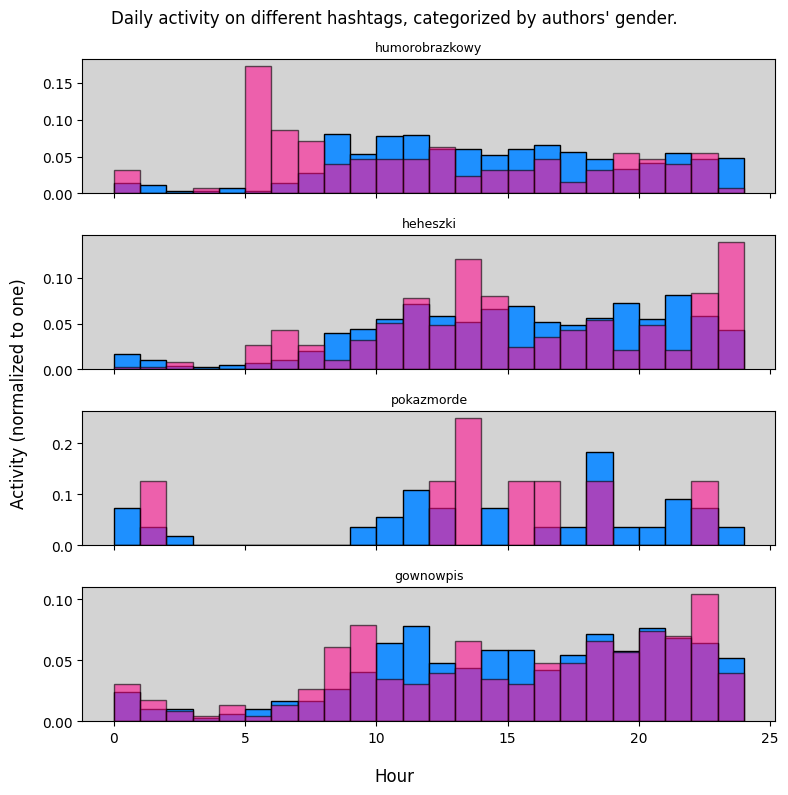

In [5]:
# TODO: y ticks to percent, x ticks every two hours, from 0 to 24 (dont show 25)

fig, axs = plt.subplots(len(raw_data), figsize=(8,8), sharex=True)
fig.set_tight_layout(True) # prevents overlaping
fig.suptitle("Daily activity on different hashtags, categorized by authors' gender.")
fig.supylabel("Activity (normalized to one)")
fig.supxlabel("Hour")

for index, ax in zip(raw_data, axs):
    table = raw_data[index].loc[:, ['author', 'created_at']].copy()
    table["author"] = table["author"].apply(lambda x: ast.literal_eval(x)['gender']) # extract author's gender
    table.created_at = table.created_at.apply(lambda t: t.hour)
    
    male = table.created_at[table.author == 'm']
    female = table.created_at[table.author == 'f']

    bins = [i for i in range(25)]

    ax.set_title(index, fontdict={"fontsize": 9})
    ax.hist(male, bins=bins, density=True, alpha=1, color='dodgerblue', edgecolor='black')
    ax.hist(female, bins=bins, density=True, alpha=0.6, color='deeppink', edgecolor='black')
    ax.set_facecolor("lightgray")

Similar to other social media platforms, <b>wykop.pl</b> offers the ability to reward posts we like (i.e., give them a vote or so-called <i>plus</i>). Let's move on then to analyzing vote distribution and statistics. Firstly, let's investigate vote statistics on different hashtags. We are going to use a box plot, which shows data distribution, median, and outliers. In this case, the number of votes is quite spread out and most of the posts don't gather many votes, so the plot would be hard to read. In order to get a better understanding of what is going on, let's look only at the most liked posts, for example those that managed to gather over 100 votes.

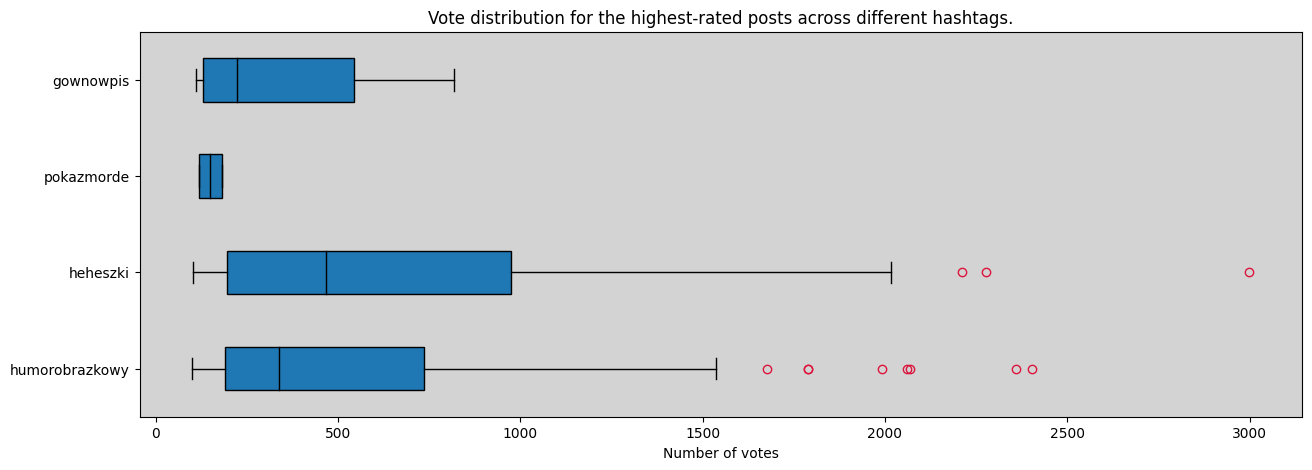

In [6]:
votes = pd.DataFrame()
fig, ax = plt.subplots(1, figsize=(15, 5))
for index in raw_data:
    table = raw_data[index]['votes']
    table = table.apply(lambda x: ast.literal_eval(x)['up'])
    table = table[table > 100]
    votes[index] = table
medianprops={'color': 'black'}
boxprops={'color': 'black'}
whiskerprops = {'color': 'black'}
capprops = {'color': 'black'}
flierprops = {'markeredgecolor': 'crimson'}
ax.set_facecolor("lightgray")
ax.set_xlabel("Number of votes")
ax.set_title("Vote distribution for the highest-rated posts across different hashtags.")

votes.plot.box(ax=ax, vert=False, patch_artist=True, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops)
plt.show()

Just like before, we might wonder how post rating depends on the author's gender. In order to check that, we could show the mean number of votes received by posts broken down by gender. We will use a double-sided bar plot for easy comparison between the data.

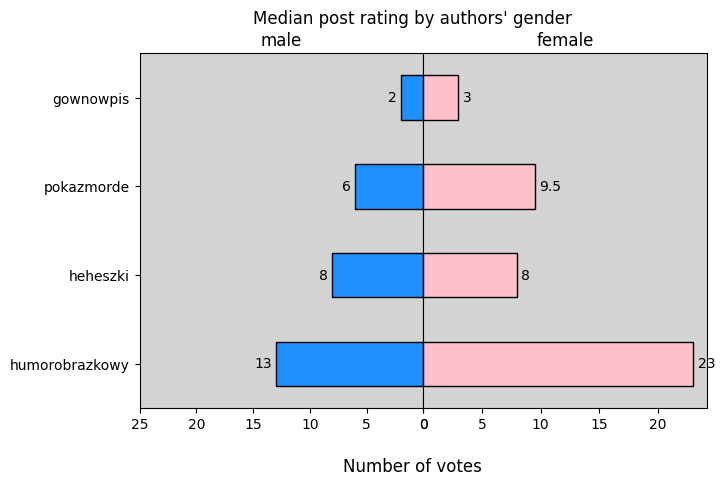

In [7]:
table_median = pd.DataFrame()
fig, (ax_m, ax_f) = plt.subplots(1, 2)
plt.suptitle("Median post rating by authors' gender")
fig.supxlabel("Number of votes")
plt.tight_layout()
plt.subplots_adjust(wspace=0)

# Retrive data
for index in raw_data:
    table = raw_data[index].loc[:, ['author', 'votes']].copy()
    table["author"] = table["author"].apply(lambda x: ast.literal_eval(x)["gender"])
    table["votes"] = table["votes"].apply(lambda x: ast.literal_eval(x)["up"])
    table = table.groupby("author").median()
    table_median[index] = table["votes"]

# Format double-sided bar chart
table_median.loc['m', :].plot.barh(ax=ax_m, color='dodgerblue', edgecolor='black')
ax_m.set_facecolor("lightgray")
ax_m.invert_xaxis()
ax_m.set_title("male")
ax_m.bar_label(ax_m.containers[0], padding=3)

table_median.loc['f', :].plot.barh(ax=ax_f, color='pink', edgecolor='black')
ax_f.set_facecolor("lightgray")
ax_f.set_yticklabels([])
ax_f.set_yticks([])
ax_f.set_title("female")
ax_f.bar_label(ax_f.containers[0], padding=3)

# Same xrange on both plots
ax_m.set_xticks(ax_f.get_xticks())
plt.show()

At the end, let's examine the correlation between two variables. As we might believe, generally, the more votes a post receives, the more comments it has (for example, because it reaches a larger audience). To verify this statement, we will plot the number of comments versus the number of votes using a scatter plot. Additionally, we will print a correlation table for each plot to gain better insight.

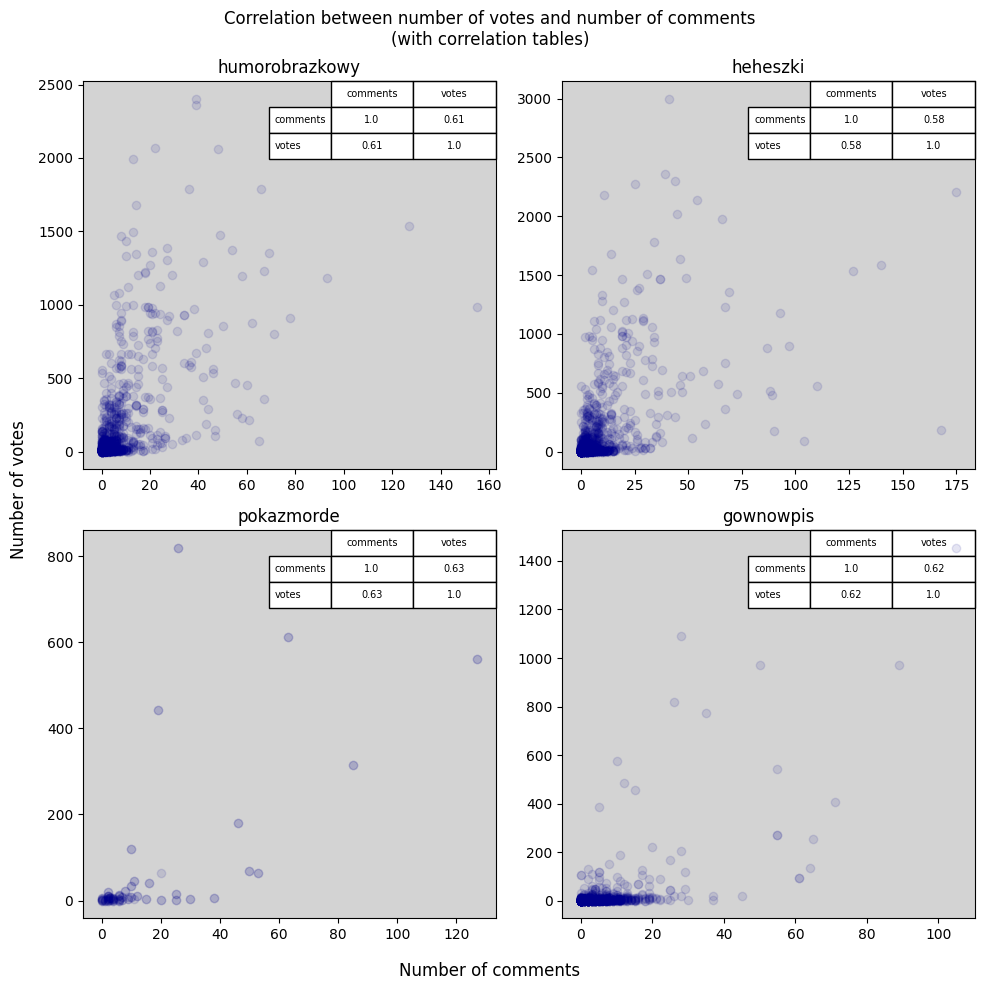

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.set_tight_layout(True) # prevents overlaping
fig.suptitle("Correlation between number of votes and number of comments\n(with correlation tables)")
fig.supylabel('Number of votes')
fig.supxlabel('Number of comments')

for index, ax in zip(raw_data, axs.flatten()):
    table = raw_data[index][['comments', 'votes']].copy()
    table["votes"] = table["votes"].apply(lambda x: ast.literal_eval(x)["up"])
    table["comments"] = table["comments"].apply(lambda x: ast.literal_eval(x)["count"])
    
    ax.scatter(table["comments"], table["votes"], alpha=0.1, color='darkblue')
    ax.set_title(index)
    
    width = 0.4
    height = 0.2 
    pd.plotting.table(ax, table.corr().round(2), cellLoc="center", bbox=[1-width, 1-height, width, height])
    #ax.table(table.corr().to_numpy())
    ax.set_facecolor("lightgray")